In [2]:
# we use pandas for data preprocessing
import pandas as pd
import numpy as np


# plot data
import matplotlib.pyplot as plt
import seaborn as sns

# we need split API from sklearn to split the data set into train/test
from sklearn.model_selection import train_test_split

# we need to Load libraries and use Tree model
from sklearn.tree import DecisionTreeClassifier

# we also need scikit-learn metrics module for accuracy calculation
from sklearn import metrics        

In [3]:
# load in the transfer fee data into dataframe
# file_path = C:\Users\tycho\Downloads
df = pd.read_csv(r'C:\Users\tycho\Downloads\final_data.csv')
transfer = df[['current_value', 'height', 'age', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets', 'minutes played', 'games_injured', 'award']]
# first 5 rows
# display(transfer.head())

# print("Dataset shape: ",transfer.shape)
# print("\nData Types:\n", transfer.dtypes)
# missing_values = transfer.isnull().sum()
# print("\nMissing values:\n", missing_values)
print("\nDescriptive Statistics:\n", transfer.describe())


Descriptive Statistics:
        current_value        height           age         goals       assists  \
count   1.075400e+04  10754.000000  10754.000000  10754.000000  10754.000000   
mean    3.622971e+06    181.240353     26.041903      0.125554      0.086978   
std     9.095410e+06      6.969818      4.777629      0.235585      0.143351   
min     0.000000e+00    156.000000     15.000000      0.000000      0.000000   
25%     3.000000e+05    176.000000     22.000000      0.000000      0.000000   
50%     8.000000e+05    181.240353     26.000000      0.045969      0.040773   
75%     3.000000e+06    186.000000     29.000000      0.172263      0.133136   
max     1.800000e+08    206.000000     43.000000     11.250000      4.000000   

       yellow cards  second yellow cards     red cards  goals conceded  \
count  10754.000000         10754.000000  10754.000000    10754.000000   
mean       0.189757             0.004666      0.006826        0.131655   
std        0.432388            

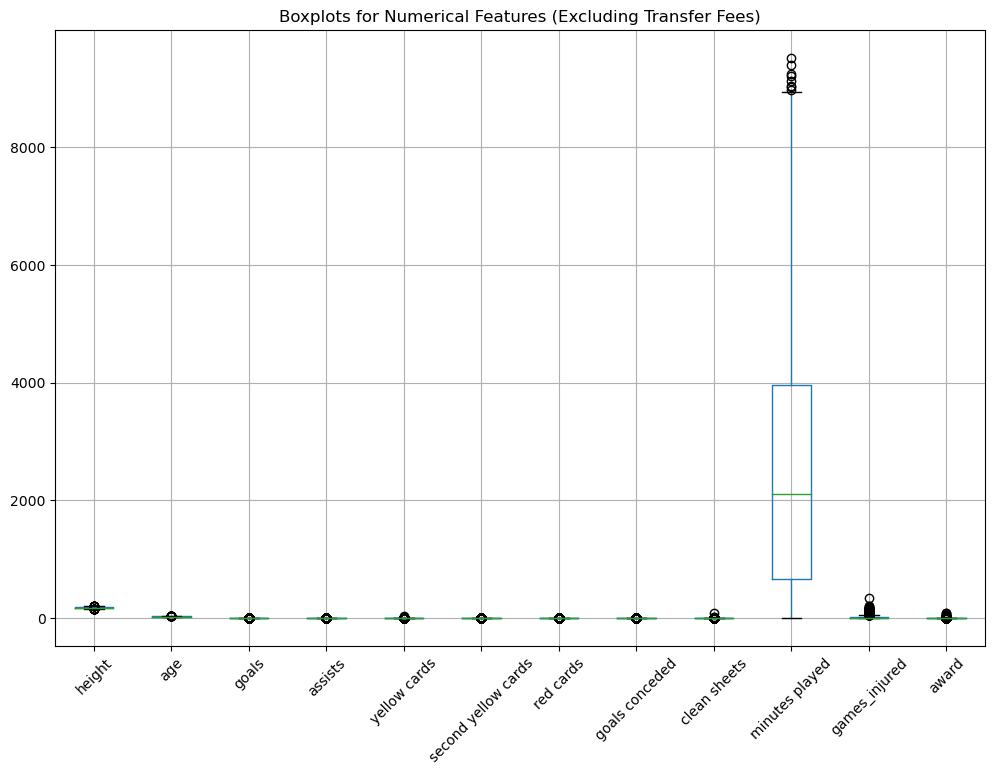

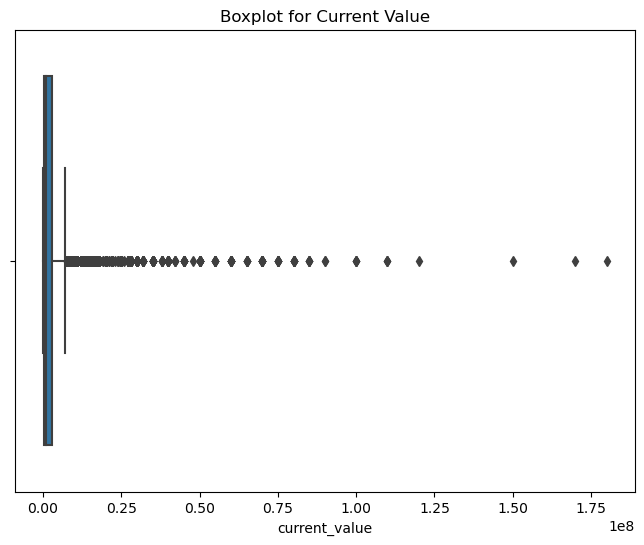

In [35]:
transfer_fee_columns = ['current_value']
other_columns = ['height', 'age', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets', 'minutes played', 'games_injured', 'award']

# Boxplots for other columns
plt.figure(figsize=(12, 8))
transfer[other_columns].boxplot()
plt.title("Boxplots for Numerical Features (Excluding Transfer Fees)")
plt.xticks(rotation=45)
plt.show()

# Boxplot for current_value
plt.figure(figsize=(8, 6))
sns.boxplot(data=transfer, x='current_value')
plt.title("Boxplot for Current Value")
plt.show()


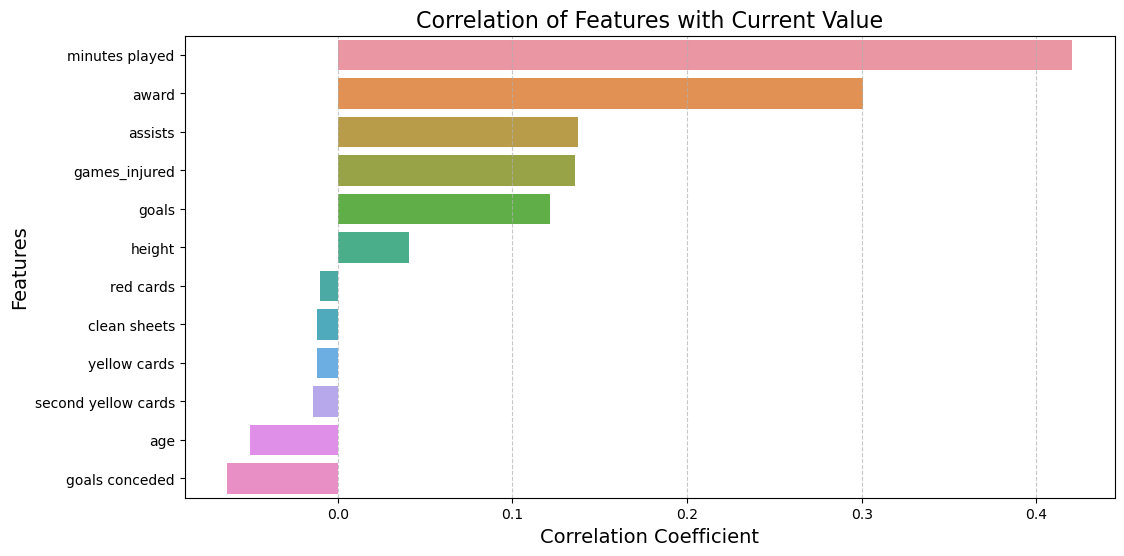

In [5]:
# Compute correlations with the target variable
correlations = transfer.corr()['current_value'].sort_values(ascending=False)

# Drop the correlation of the target variable with itself (1.0)
correlations = correlations.drop('current_value')

# Plot the correlations as a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.values, y=correlations.index)

# Add labels and title
plt.title('Correlation of Features with Current Value', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Display gridlines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()



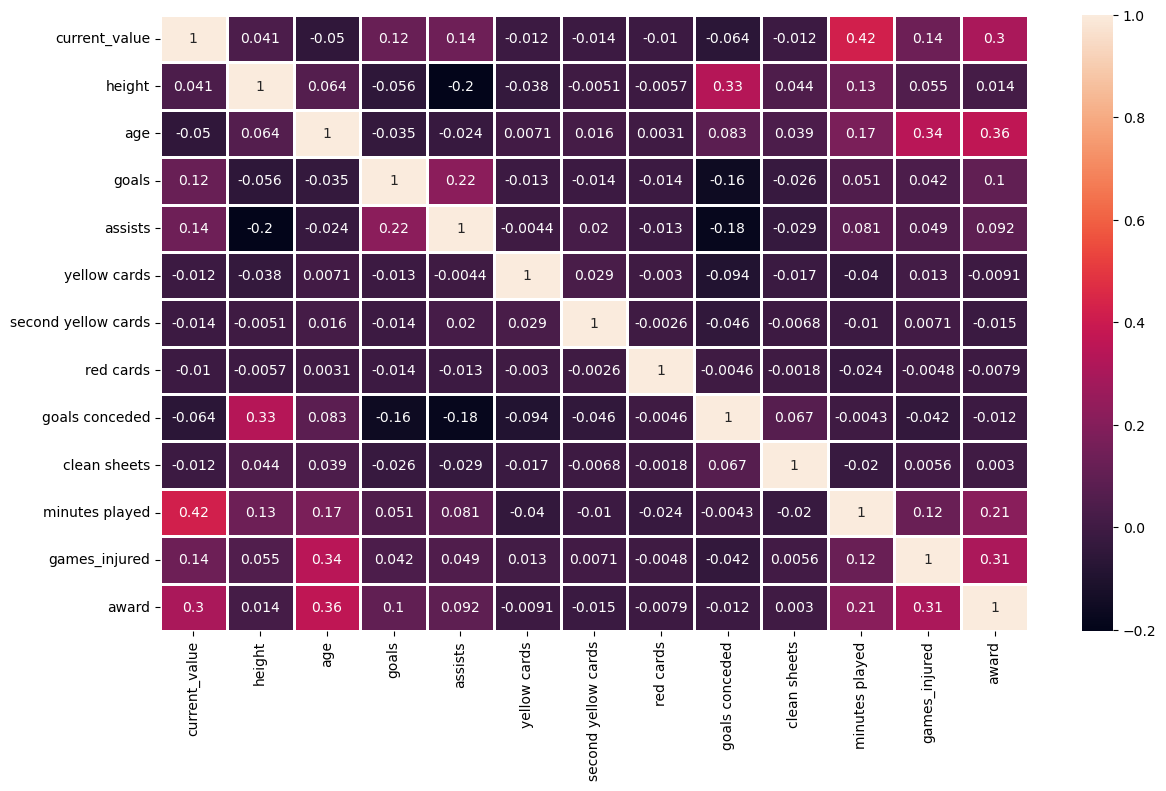

In [6]:
# use a bigger size
plt.figure(figsize=(14, 8))

# correlation heatmap
sns.heatmap(transfer.corr(), annot=True, linewidth =1)

plt.show() 

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

X = transfer[other_columns]
y = transfer['current_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)


cv_scores = cross_val_score(rf_model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')

Cross-Validation Scores: [ 0.09313424  0.33344983 -2.92707113 -0.86003482 -7.00621695]


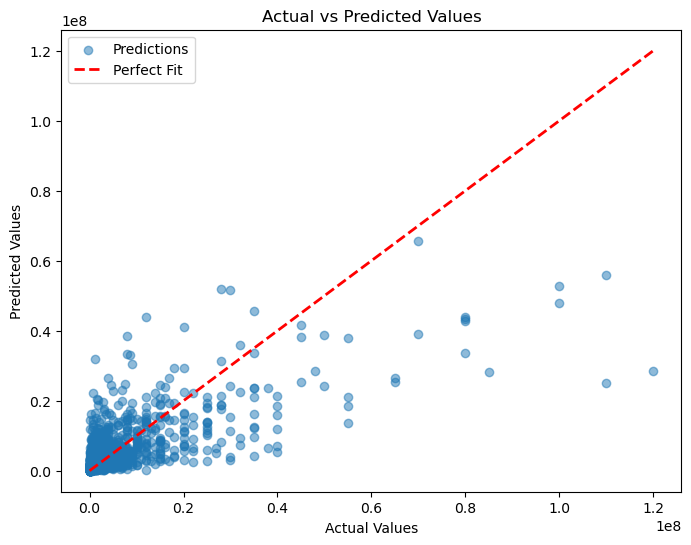

In [8]:
# Predictions from Random Forest model
y_pred_rf = rf_model.predict(X_test)

# Scatter plot for actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

In [10]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],       
    'max_depth': [None, 10, 20],          
    'min_samples_split': [2, 5, 10],      
    'min_samples_leaf': [1, 2, 4]         
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,                
    cv=3,                     
    n_jobs=-1,                
    verbose=2,               
    random_state=42           
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Display the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.48837055446898847


In [19]:
## Since the optimized Random forest regressor has the best CV score of 0.48,
## we should look if we can optimize it more by looking at the data

transfer_modified = transfer.copy()

# method to cap outliers
def cap_outliers(df, columns):
    for col in columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = np.clip(df[col], lower, upper)
    return df

columns_to_cap = ['current_value'] + other_columns
transfer_modified = cap_outliers(transfer_modified, columns_to_cap)


X_modified = transfer_modified[other_columns]
y_modified = transfer_modified['current_value']


X_train_modified, X_test_modified, y_train_modified, y_test_modified = train_test_split(X_modified, y_modified, test_size=0.2, random_state=42)


param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)


random_search.fit(X_train_modified, y_train_modified)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.4952505237511546


with capped outliers and current_value_log (deleted since performed worse):
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.39082743019897287

with capped outliers and current_value:
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.4952505237511546

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

best_rf_model = random_search.best_estimator_

y_pred_test = best_rf_model.predict(X_test_modified)

rmse = np.sqrt(mean_squared_error(y_test_modified, y_pred_test))
r2 = r2_score(y_test_modified, y_pred_test)

print(f"Test Set RMSE: {rmse}")
print(f"Test Set R-squared: {r2}")


Test Set RMSE: 4815892.064515973
Test Set R-squared: 0.5561897823200554


C:\Users\tycho\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\tycho\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\tycho\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\tycho\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\tycho\anaconda3\Lib\site-packages\sklearn\preprocessing\_discre

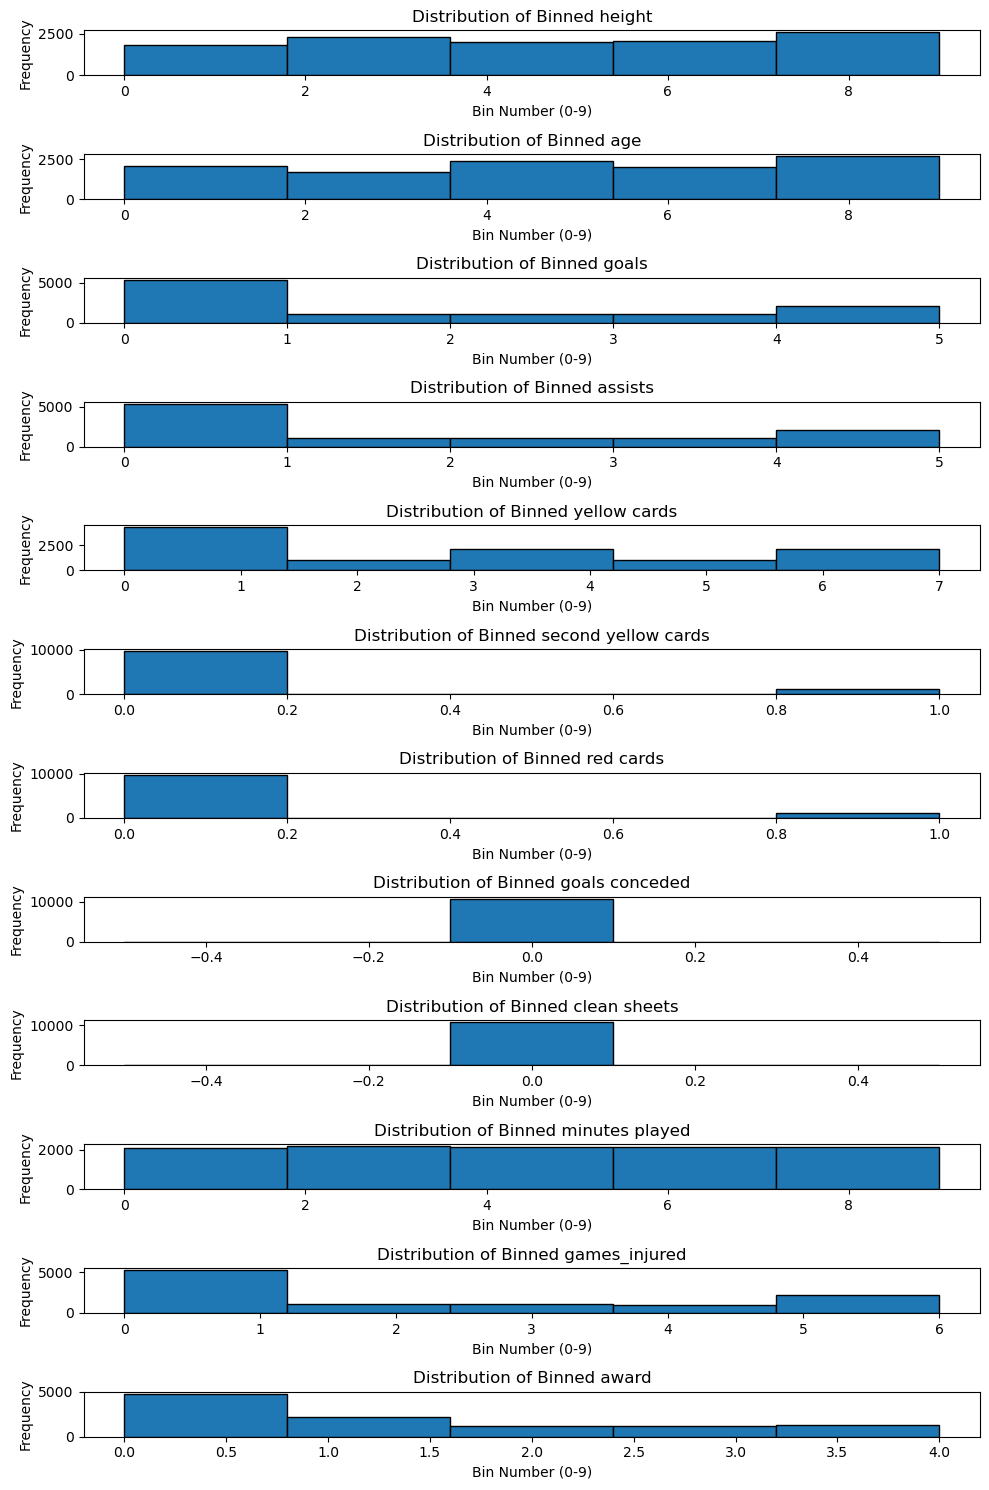

In [24]:
from sklearn.preprocessing import KBinsDiscretizer


features_to_bin = transfer_modified[other_columns]

# initialize binner to bin dataset
binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
binned_features = binner.fit_transform(features_to_bin)

# Plot the distribution of binned values for each feature
fig, axes = plt.subplots(len(other_columns), 1, figsize=(10, 15))
for idx, col in enumerate(other_columns):
    axes[idx].hist(binned_features[:, idx], bins=5, edgecolor='black')
    axes[idx].set_title(f'Distribution of Binned {col}')
    axes[idx].set_xlabel(f'Bin Number (0-9)')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [29]:
transfer_modified['player'] = df['player']  
df_position = df[['player', 'position_encoded']]

# Now merge
transfer_modified = transfer_modified.merge(df_position, on='player', how='left')

# bin the sparse features into two categories
transfer_modified['second_yellow_binned'] = transfer_modified['second yellow cards'].apply(lambda x: 1 if x > 0 else 0)
transfer_modified['red_card_binned'] = transfer_modified['red cards'].apply(lambda x: 1 if x > 0 else 0)

# for goalkeepers, create bins for goals conceded and clean sheets, otherwise handle as continuous for others
transfer_modified['goals_conceded_binned'] = transfer_modified.apply(lambda row: 1 if row['position_encoded'] == 1 and row['goals conceded'] > 0 else 0, axis=1)
transfer_modified['clean_sheets_binned'] = transfer_modified.apply(lambda row: 1 if row['position_encoded'] == 1 and row['clean sheets'] > 0 else 0, axis=1)


In [30]:
# Handle goalkeeper-specific metrics
goalkeeper_features = ['goals conceded', 'clean sheets']

# Remove non-goalkeepers' values for these metrics
for col in goalkeeper_features:
    transfer_modified.loc[transfer_modified['position_encoded'] != 1, col] = 0

In [38]:
X = transfer_modified.drop(columns=['current_value', 'player', 'goals conceded', 'clean sheets'] + goalkeeper_features)

y = transfer_modified['current_value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest with hyperparameter tuning
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.4943793156618357


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 2447075.637155298
Mean Squared Error (MSE): 23146538840406.113
Root Mean Squared Error (RMSE): 4811084.996173536
R² Score: 0.5570753342636252


Not binned:
Mean Absolute Error (MAE): 2444658.567769861
Mean Squared Error (MSE): 23192816377067.92
Root Mean Squared Error (RMSE): 4815892.064515973
R² Score: 0.5561897823200554

binned independent variables:
Mean Absolute Error (MAE): 2447075.637155298
Mean Squared Error (MSE): 23146538840406.113
Root Mean Squared Error (RMSE): 4811084.996173536
R² Score: 0.5570753342636252

                  Feature  Importance
7          minutes played    0.367923
1                     age    0.161036
9                   award    0.144049
8           games_injured    0.091206
2                   goals    0.074920
3                 assists    0.058402
4            yellow cards    0.048810
0                  height    0.032661
6               red cards    0.006384
5     second yellow cards    0.006326
12       position_encoded    0.006047
10   second_yellow_binned    0.001126
11        red_card_binned    0.000679
14    clean_sheets_binned    0.000326
13  goals_conceded_binned    0.000105


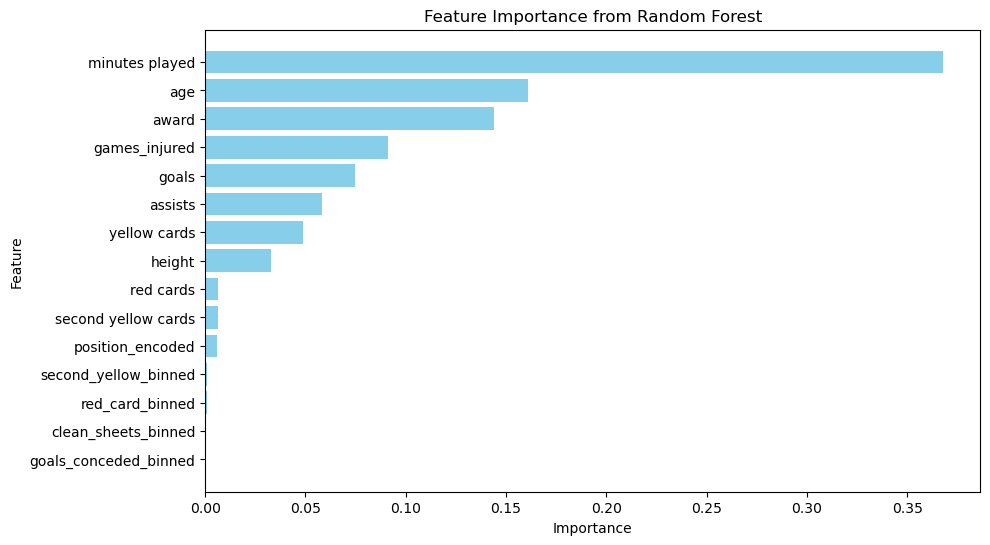

In [40]:
# Get feature importance from the best random forest model
feature_importances = best_rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot 
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()


In [44]:
## binning the target variable to improve model

bins = 10 
transfer_modified['current_value_bin'] = pd.qcut(transfer_modified['current_value'], bins, labels=False)

# balance data set
balanced_data = transfer_modified.groupby('current_value_bin', group_keys=False).apply(
    lambda x: x.sample(n=transfer_modified['current_value_bin'].value_counts().min(), random_state=42)
)


# Remove target, player, and other unnecessary columns in both train and test data
X_balanced = balanced_data.drop(columns=['current_value', 'current_value_bin', 'player'])
X_balanced = X_balanced.drop(columns=['goals conceded', 'clean sheets']) 

y_balanced = balanced_data['current_value']


X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=balanced_data['current_value_bin']
)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit model
random_search.fit(X_train_balanced, y_train_balanced)

# Output
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None}
Best CV score: 0.5102136971406587


In [45]:
# Predict using the best model
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test_balanced)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_balanced, y_pred)
mse = mean_squared_error(y_test_balanced, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_balanced, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 2592410.414411537
Mean Squared Error (MSE): 27478524430450.336
Root Mean Squared Error (RMSE): 5241996.225718819
R² Score: 0.516098157033191


                  Feature  Importance
7          minutes played    0.357002
1                     age    0.172067
9                   award    0.150908
8           games_injured    0.094687
2                   goals    0.065300
3                 assists    0.060502
4            yellow cards    0.048271
0                  height    0.030740
12       position_encoded    0.007378
5     second yellow cards    0.006164
6               red cards    0.004604
11        red_card_binned    0.001146
10   second_yellow_binned    0.000788
14    clean_sheets_binned    0.000364
13  goals_conceded_binned    0.000080


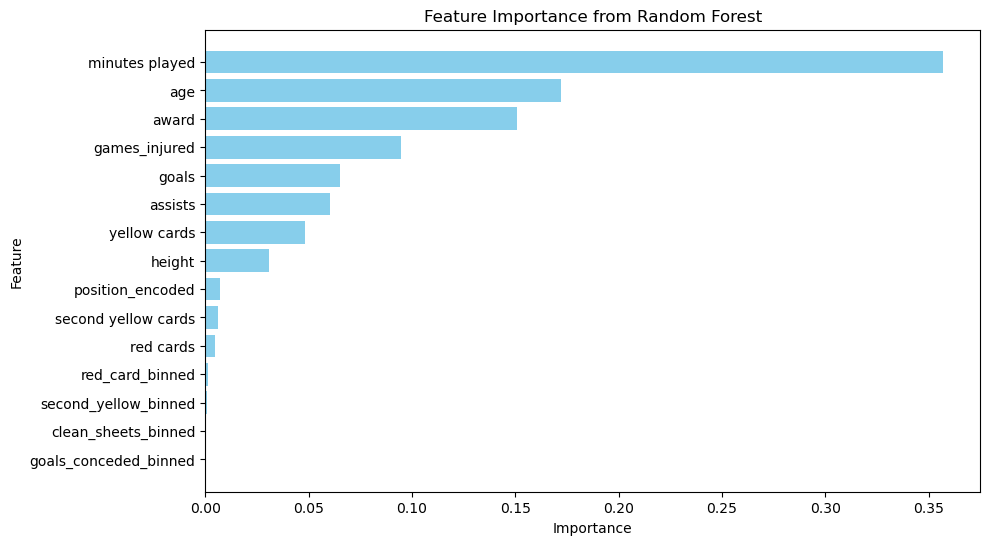

In [46]:
# Get feature importance from the best random forest model
feature_importances = best_rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()


In [47]:
# Select the specified features
selected_features = ['minutes played', 'age', 'award', 'games_injured', 'goals', 'assists', 'yellow cards', 'height']
X_selected = transfer_modified[selected_features]
y_selected = transfer_modified['current_value']

# Train-test split
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(
    X_selected, y_selected, test_size=0.2, random_state=42
)

# Random Forest with hyperparameter tuning
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_selected = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
random_search_selected.fit(X_train_selected, y_train_selected)

# Output best parameters and cross-validation score
print("Best parameters:", random_search_selected.best_params_)
print("Best CV score:", random_search_selected.best_score_)

# Best model
best_rf_model_selected = random_search_selected.best_estimator_

# Make predictions
y_pred_selected = best_rf_model_selected.predict(X_test_selected)

# Calculate evaluation metrics
mae_selected = mean_absolute_error(y_test_selected, y_pred_selected)
mse_selected = mean_squared_error(y_test_selected, y_pred_selected)
rmse_selected = np.sqrt(mse_selected)
r2_selected = r2_score(y_test_selected, y_pred_selected)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae_selected}")
print(f"Mean Squared Error (MSE): {mse_selected}")
print(f"Root Mean Squared Error (RMSE): {rmse_selected}")
print(f"R² Score: {r2_selected}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
Best CV score: 0.49622719696981815
Mean Absolute Error (MAE): 2491474.5100237816
Mean Squared Error (MSE): 23666540835922.69
Root Mean Squared Error (RMSE): 4864826.907087516
R² Score: 0.5471247446037852


After binning of features, binning of target variable, log transformation and feature selection, no big improvement was made in terms of the metric scores so now trying to see if a different model might perform better.

In [54]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define parameter grid for tuning
param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.1, 1, 10]
}


xgb_model = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,  
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)


random_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

# Make predictions and evaluate
best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost - Mean Absolute Error (MAE): {mae}")
print(f"XGBoost - Mean Squared Error (MSE): {mse}")
print(f"XGBoost - Root Mean Squared Error (RMSE): {rmse}")
print(f"XGBoost - R² Score: {r2}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best CV score: 0.5014709602293376
XGBoost - Mean Absolute Error (MAE): 2393944.778818355
XGBoost - Mean Squared Error (MSE): 22338323846207.047
XGBoost - Root Mean Squared Error (RMSE): 4726343.602215887
XGBoost - R² Score: 0.5725410744599018
